<a href="https://colab.research.google.com/github/arkothiwala/Analytics-Vidhya/blob/master/AV_GoD_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import torch
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 48.1MB/s 


In [0]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1zRzgwnzMs52MN674v6TFDOMrKi1jg6dN' #File ID for the required Trainingdata
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train-ship classification.zip')

In [0]:
import zipfile
zip_ref = zipfile.ZipFile('train-ship classification.zip', 'r')
zip_ref.extractall('data')
zip_ref.close()

In [4]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [5]:
train_csv = pd.read_csv('./data/train.csv')
train_csv.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [6]:
train_csv.category.value_counts()

1    2120
5    1217
2    1167
3     916
4     832
Name: category, dtype: int64

In [0]:
#shutil.rmtree('./images')
os.mkdir('./train')
os.mkdir('./validation')
for i in range(1,6):
  os.mkdir('./train/{}/'.format(i))
  os.mkdir('./validation/{}/'.format(i))

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
x,y = train_test_split(train_csv, test_size=0.3)

In [0]:
import os
import shutil

#os.rename("path/to/current/file.foo", "path/to/new/destination/for/file.foo")
#shutil.move("path/to/current/file.foo", "path/to/new/destination/for/file.foo")

In [0]:
for i in range(len(x)):
  category = x.category.iloc[i]
  image_name = x.image.iloc[i]
  os.rename("./data/images/{}".format(image_name) ,"./train/{}/{}".format(category, image_name))
  
for i in range(len(y)):
  category = y.category.iloc[i]
  image_name = y.image.iloc[i]
  os.rename("./data/images/{}".format(image_name) ,"./validation/{}/{}".format(category, image_name))

### Transfer learning without removing existing layers





In [12]:

base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(5,activation='softmax')(x) #final layer with softmax activation

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 2s 0us/step


### Transfer learning by removing existing layers

In [0]:
model=Model(inputs=base_model.input,outputs=preds)

In [0]:
for layer in model.layers:
    layer.trainable=False
for layer in model.layers[-4:]:
    layer.trainable=True

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
__________

In [66]:
len(model.layers)

91

In [16]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('./train/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 4376 images belonging to 5 classes.


In [17]:
validation_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

validation_generator=validation_datagen.flow_from_directory('./validation/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 1876 images belonging to 5 classes.


In [0]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
step_size_validation=validation_generator.n//validation_generator.batch_size

In [22]:
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                    validation_data=validation_generator,
                    validation_steps = step_size_validation,
                   epochs=30)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
68/68 [==============================] - 13s 185ms/step - loss: 0.9450 - acc: 0.6907 - val_loss: 0.5293 - val_acc: 0.7877
Epoch 2/30
68/68 [==============================] - 10s 147ms/step - loss: 0.3665 - acc: 0.8656 - val_loss: 0.6243 - val_acc: 0.7506
Epoch 3/30
68/68 [==============================] - 10s 147ms/step - loss: 0.2904 - acc: 0.8913 - val_loss: 0.4851 - val_acc: 0.8118
Epoch 4/30
68/68 [==============================] - 9s 139ms/step - loss: 0.2363 - acc: 0.9086 - val_loss: 0.8687 - val_acc: 0.7070
Epoch 5/30
68/68 [==============================] - 10s 140ms/step - loss: 0.1905 - acc: 0.9242 - val_loss: 0.5890 - val_acc: 0.7958
Epoch 6/30
68/68 [==============================] - 10s 142ms/step - loss: 0.1892 - acc: 0.9289 - val_loss: 0.6584 - val_acc: 0.7699
Epoch 7/30
68/68 [==============================] - 10s 143ms/step - loss: 0.1455 - acc: 0.9454 - val_loss: 0.6556 - val_acc: 0.8013
Epoch 8/30
68/68 [====

In [0]:
#filenames = test_generator.filenames
#nb_samples = len(filenames)

#predict = model.predict_generator(test_generator,steps = nb_samples)

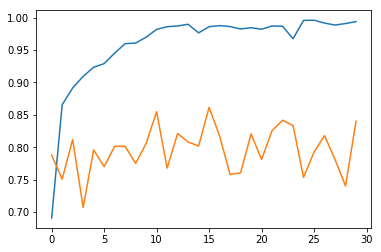

In [23]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

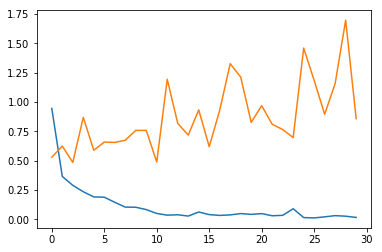

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [56]:
nb_samples

1876

# Getting Test Data from Analytics Vidhya

In [0]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1B2QDCOTjkvMJ0O5xi37VQR6EecSeOWU2' #File ID for the required Trainingdata
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test-ship classification.zip')

In [29]:
import zipfile
zip_ref = zipfile.ZipFile('test-ship classification.zip', 'r')
zip_ref.extractall('test_data')
zip_ref.close()

BadZipFile: ignored

In [0]:
os.rename('./test-ship classification.zip','./test.csv')

In [31]:
pd.read_csv('./test.csv')

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg
5,1072861.jpg
6,1097264.jpg
7,1098763.jpg
8,1098766.jpg
9,1101145.jpg


In [85]:
len([name for name in os.listdir('./data/images/')])

8932

In [86]:
8932-2680

6252

In [0]:
shutil.rmtree('./test')

In [33]:
Test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

Test_generator=Test_datagen.flow_from_directory('./data/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical')

Found 2680 images belonging to 2 classes.


In [0]:
shutil.rmtree('./data/__MACOSX/')

In [0]:
filenames = Test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(Test_generator,steps = 42)

In [35]:
len(predict)

2680

In [0]:
ans = np.argmax(predict, axis=1)

In [39]:
test_csv = pd.read_csv('./test.csv', index=False)

TypeError: ignored

In [0]:
test_csv['category'] = ans

In [0]:
test_csv.to_csv('submission.csv', index=False)

In [40]:
test_csv.head()

,image,category
0,1007700.jpg,0
1,1011369.jpg,3
2,1051155.jpg,0
3,1062001.jpg,2
4,1069397.jpg,1
